***
    
Demo JAX for PINN (Physics-Informed Neural Network)
    
***

    Version: 2023-02-24
    
    Author : Nicholas Sung Wei Yong, Wong Jian Cheng, Ooi Chin Chun, Abhishek Gupta

    Contain:
    
    1. PINN for solving convection-diffusion equation (1D linear convection)
    
    2. Optimize PINN using batch gradient descent on the JAX framework
       -  as described in Nicholas Sung Wei Yong, Jian Cheng Wong, Pao-Hsiung Chiu, Abhishek Gupta, Chinchun Ooi, Yew-Soon Ong
       "Neuroevolution Surpasses Stochastic Gradient Descent for Physics-Informed Neural Networks" arXiv preprint arXiv:2212.07624 (2022).

Import Libraries

In [1]:
import jax
import optax
import time
import matplotlib.pyplot as plt
from typing import Any, Callable, Sequence, Optional
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax.config import config

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

PINNs Network

In [2]:
n_nodes = 10
# Set up a class for the neural network
class PINNs(nn.Module):
    """PINNs"""
    def setup(self):
        self.layers = [nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                       nn.tanh,
                       nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                       nn.tanh,
                       nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                       nn.tanh,
                       nn.Dense(1, kernel_init = jax.nn.initializers.glorot_uniform(), use_bias=False)]
    # Setting x as the inputs and saving the outputs, u, u_x, and u_xx     
    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        x, w = inputs[:,0:1], inputs[:,1:2]
        
        def get_u(x,w):
            u = x
            for i, lyr in enumerate(self.layers):
                u = lyr(u)
            return u
        
        u = get_u(x, w)
        
        # obtain u_x
        def get_u_x(get_u, x, w):
            u_x = jacfwd(get_u)(x, w)
            return u_x
        
        u_x_vmap = vmap(get_u_x, in_axes=(None, 0, 0))
        u_x = u_x_vmap(get_u, x, w).reshape(-1,1)  
        
        #obtain u_xx    
        def get_u_xx(get_u, x, w):
            u_xx = hessian(get_u)(x,w)
            return u_xx
        
        u_xx_vmap = vmap(get_u_xx, in_axes=(None, 0, 0))
        u_xx = u_xx_vmap(get_u, x, w).reshape(-1,1)  
        
        action = jnp.hstack([u,u_x, u_xx])   
        return action

# initialize model
model = PINNs()    

In [3]:
# Initialization of the weights and biases
# choose seed
seed = 0
key1, key2 = random.split(random.PRNGKey(seed))
a = random.normal(key1, [1,1]) # Dummy input
params = model.init(key2, a) # Initialization call

In [4]:
from evojax.util import get_params_format_fn
num_params, format_params_fn = get_params_format_fn(params)
num_params

250

Problem

In [5]:
# Function to generate ground truth
def eval_u(x, Pe, L):
    u = (1. - jnp.exp(Pe*x/L)) / (1. - jnp.exp(Pe))
    return u

def eval_Pe(u, k, L):
    return u*L/k

# f: IC/BC
def tf_bc(x):
    u = (1. - jnp.exp(Pe*x/L)) / (1. - jnp.exp(Pe))
    return u

Hyper parameters and data 

In [6]:
# choose v (PDE parameter)
v = 6

# fixed PDE & BC parameters k & L
k = 1.
L = 1.
Pe = eval_Pe(v, k, L)

# domain Boundary
x_l, x_u = 0, L

# sample size
n = 10000

# PDE data
x_pde = jnp.linspace(x_l, x_u, n)
data_pde = jnp.hstack([x_pde.reshape(-1, 1), jnp.ones((len(x_pde), 1))])
labels_pde = jnp.reshape(eval_u(x_pde, Pe, L),(-1, 1))

Loss Function

In [7]:
# loss function parameter
lmbda = 1 #500

In [8]:
# split the loss into pde loss and bc loss

def loss(params):
    x = data_pde
    pred = model.apply(format_params_fn(params), x)
    u, u_x, u_xx = pred[:,0:1], pred[:,1:2], pred[:,2:3]
    t_u = tf_bc(x) # ground truth
    _bc = jnp.where((jnp.equal(x, x_l) | jnp.equal(x, x_u)), 1, 0)
    bc_mse = jnp.sum(jnp.square((t_u - u)*_bc)) / jnp.sum(_bc)
    # PDE (physics laws): v*u_x = k*u_xx  
    pde = v*u_x - k*u_xx
    # exclude BC points
    _pde = jnp.where((jnp.equal(x, x_l) | jnp.equal(x, x_u)), 0, 1)
    pde = pde *_pde
    pde_mse = jnp.sum(jnp.square(pde)) / jnp.sum(_pde)
    pde_mse = pde_mse / lmbda  
    loss = pde_mse + bc_mse
    return loss
  
#loss_grad = jax.jit(jax.grad(loss))
loss_grad = jax.jit(jax.value_and_grad(loss))    

Weights Update

In [9]:
def update(params, opt_state):
    loss_value, grad = loss_grad(params)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

update = jit(update)

Initialization

In [10]:
# initial params
params = model.init(key2, a) # Initialization call

# flatten initial params
params = jax.flatten_util.ravel_pytree(params)[0]

Optimizer

In [11]:
alpha = 0.001
#optimizer = optax.adam(learning_rate=alpha) # Choose the method
optimizer = optax.sgd(learning_rate=alpha) # Choose the method
opt_state = optimizer.init(params)

Training 

In [12]:
max_iters = 500000
loss_ls = []
t_training = []
runtime = 0
train_iters = 0
while (train_iters < max_iters) and (runtime < 60):
    start = time.time()
    # stochastic update
    #batch_data = minibatch(train_iters)
    
    params, opt_state, loss_value = update(params, opt_state)
    end = time.time()
    t_training.append(end-start)
    loss_ls.append(loss_value)
    runtime += (end-start)
    train_iters += 1    
    # append weights
    show_iters = [1000, 5000, 10000, 50000, 100000]
    if (train_iters in show_iters):
        print('Loss step {}: '.format(train_iters), loss_value)
              
# final train_iters
train_iters

Loss step 1000:  0.003325644
Loss step 5000:  0.0008823679
Loss step 10000:  0.00034946884
Loss step 50000:  0.00010033038
Loss step 100000:  0.00010000096


165142

#### Visualize results

DeviceArray(0.75435865, dtype=float32)

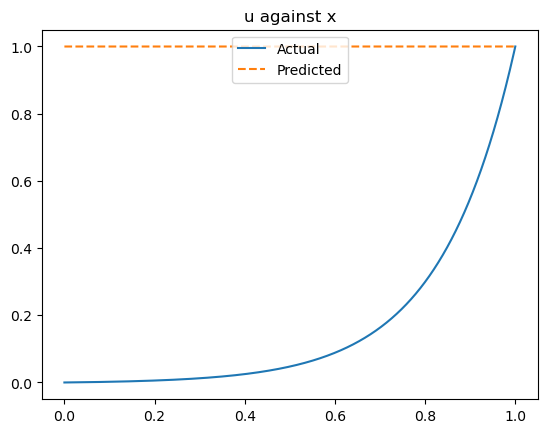

In [13]:
# plot final
hello = PINNs()
prediction = hello.apply(format_params_fn(params), data_pde)
u = prediction[:,0:1]

plt.plot(x_pde, labels_pde, label = "Actual"); plt.plot(x_pde, u, '--', label = "Predicted");
plt.legend(loc='upper center'); plt.title('u against x');
jnp.mean(jnp.square(labels_pde - u))